# ML Term Paper - Code: Models
by Ann-Christin and Sarah 15/02/2021

## 1. Preparation

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split


from sklearn import ensemble
from sklearn import tree as tree

# set color theme
sns.set_theme()

#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [4]:
import os
path = "E:/Data/krea/PIAAC" #enter your path here
#path = "C:/Users/gust/Documents/ML_term_paper"
os.chdir(path)
print("done")
data = pd.read_csv("Data/piaac_red.csv", sep=',', error_bad_lines=False, index_col=False)
data.shape

done


E:\Anaconda3\envs\base-krea\lib\site-packages\IPython\core\interactiveshell.py:3156: DtypeWarning: Columns (1,4,11,17,22,24,25,28,30,31,38,47,50,57,58,59,62,63,65,68,75,84,85,86,92) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(230691, 129)

In [5]:
data.describe()

,Unnamed: 0,inpiaac,seqid,age_r,j_q03b,j_q03b_c,racethn_5cat,yrsqual,yrsqual_t,yrsget,...,readytolearn,icthome,ictwork,earnmthallppp,earnmthbonusppp,earnmthselfppp,nfehrsnjr,nfehrsjr,nfehrs,unempflag
count,230691.000000,3660.000000,230691.000000,166949.000000,103091.000000,144543.000000,3472.000000,218593.000000,213568.000000,125736.000000,...,226734.000000,171755.000000,102478.000000,8.850800e+04,7.677600e+04,11732.000000,54687.000000,54687.000000,80121.000000,3477.000000
mean,115345.000000,0.900546,4401.442982,39.687485,2.258296,2.165992,2.247408,12.536184,12.546814,12.567069,...,2.037301,2.028157,2.016022,3.157575e+03,3.259009e+03,2493.775348,55.298554,84.441805,140.938755,0.039689
std,66594.899812,0.299311,4735.160301,14.302125,1.264413,0.940666,0.982485,3.289158,3.300026,3.516878,...,1.024525,1.008360,1.021538,6.821093e+04,7.313718e+04,9771.976917,198.082778,196.587656,301.342789,0.195257
min,0.000000,0.000000,1.000000,16.000000,1.000000,1.000000,1.000000,3.000000,3.000000,0.000000,...,-1.074991,-1.209050,0.008980,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,57672.500000,1.000000,1649.000000,27.000000,1.000000,1.000000,2.000000,11.000000,11.000000,11.000000,...,1.355049,1.338901,1.210520,9.259300e+02,1.016686e+03,200.162500,0.000000,9.000000,16.000000,0.000000
50%,115345.000000,1.000000,3298.000000,39.000000,2.000000,2.000000,2.000000,12.000000,12.000000,13.000000,...,1.992110,2.088670,1.854941,1.790609e+03,1.864409e+03,1014.449100,0.000000,30.000000,40.000000,0.000000
75%,173017.500000,1.000000,5008.000000,52.000000,3.000000,3.000000,2.000000,15.000000,15.000000,15.000000,...,2.588965,2.683840,2.624086,3.177483e+03,3.212351e+03,2827.312600,20.000000,80.000000,112.000000,0.000000
max,230690.000000,1.000000,27285.000000,65.000000,25.000000,4.000000,6.000000,23.000000,23.000000,23.000000,...,4.643640,7.710160,5.463352,1.187756e+07,1.187756e+07,856174.200000,1920.000000,1920.000000,1920.000000,1.000000


In [6]:
data.head()


,Unnamed: 0,cntryid,inpiaac,seqid,cnt_brth,ageg10lfs,age_r,gender_r,j_q03b,j_q03b_c,...,nfe12jr,nfe12njr,fnfaet12,fnfaet12jr,fnfaet12njr,nfehrsnjr,nfehrsjr,nfehrs,nopaidworkever,unempflag
0,0,84093.0,1.0,9355.0,NaN,NaN,NaN,Male,NaN,3.0,...,Did not participate in NFE for JR reasons,Did not participate in NFE for NJR reasons,Did not participate in formal or non-formal AET,Did not participate in formal or non-formal AE...,Did not participate in formal or non-formal AE...,NaN,NaN,NaN,Has had paid work,0.0
1,1,84093.0,1.0,10882.0,NaN,NaN,NaN,Male,NaN,NaN,...,Participated in NFE for JR reasons,Did not participate in NFE for NJR reasons,Participated in formal and/or non-formal AET,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,0.0,30.0,30.0,Has had paid work,0.0
2,2,84093.0,1.0,12329.0,NaN,NaN,NaN,Female,NaN,4.0,...,Did not participate in NFE for JR reasons,Did not participate in NFE for NJR reasons,Did not participate in formal or non-formal AET,Did not participate in formal or non-formal AE...,Did not participate in formal or non-formal AE...,NaN,NaN,NaN,Has had paid work,0.0
3,3,84093.0,1.0,10711.0,NaN,NaN,NaN,Female,NaN,NaN,...,Participated in NFE for JR reasons,Did not participate in NFE for NJR reasons,Participated in formal and/or non-formal AET,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,NaN,NaN,8.0,Has had paid work,0.0
4,4,84093.0,1.0,10383.0,NaN,NaN,NaN,Male,NaN,1.0,...,Participated in NFE for JR reasons,Did not participate in NFE for NJR reasons,Participated in formal and/or non-formal AET,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,0.0,80.0,80.0,Has had paid work,0.0


In [8]:
# data cleaning, drop variables that have too few observations,are not relevant or collinear
dcl = data.drop(columns = ['Unnamed: 0', 'inpiaac', "racethn_5cat", "unempflag", "racethn_5cat", "c_q08c2", "seqid", "b_q04b", "b_q19a", 
                         "c_q08c2", "learnatwork", "nfehrsnjr", "nfehrsjr", "nfehrs", "earnmthselfppp", "d_q05b2", 
                          "yrsqual_t", "earnmthbonusppp",  "d_q16d5", "c_q02c", "isco1c", "c_d09", "isic1l", "cnt_h", "isced_hf", "isco1l", "isco1c", "c_d05",
                          'icthome','ictwork','b_q01a','b_q01a_t','yrsqual','ageg10lfs','cnt_brth','fnfaet12jr', 'fe12', 'aetpop', 'faet12', 'faet12jr', 'faet12njr', 
                           'nfe12', 'nfe12jr', 'nfe12njr', 'fnfaet12', 'fnfaet12jr', 'fnfaet12njr']) # exlude those to test the results 
#"isic2l", "isic2c", "isic_cus_c", "isic_lus_c", "isic4_c", "isic4_l",'cntry', 'cntry_e',

# further exclude 
dcl = dcl.drop(columns = ['d_q16b', 'b_q20b', 'b_d12h', 'b_q02a_t2', 'b_q11', 'b_q12e', 'b_q12a', 'd_q12a' , 'b_q04a', 'b_q16', 'b_q26b', 'b_q15c', 'd_q06c', 'b_q15b', 'd_q05a2', 
                          'b_q13', 'b_q15a', 'b_q16', 'b_q12c', 'b_q02a', 'b_q02a_t1', 'b_q05c', 'b_q10b', 'c_d06', 'd_q04', 'b_q12g', 'b_q12a'])


dcl = dcl.loc[:, ~dcl.columns.str.endswith('_c')]
#drop if skill level is missing 
#dcl = dcl[dcl.iscoskil4 != "A"]
#dcl = dcl[dcl.iscoskil4 != "N"]
#dcl = dcl[dcl.iscoskil4 != "U"]

In [9]:
#dcl['d_q05a2'] = dcl['d_q05a2'].astype('object')
dcl['gender_r'] = dcl['gender_r'].astype('category')
dcl["age_r"] = pd.to_numeric(dcl["age_r"])
#dcl['b_q12a'] = dcl['b_q12a'].astype('category') # yes/no open educational training
dcl['b_q12b'] = pd.to_numeric(dcl["b_q12b"]) # number of open/distance educational trainings
dcl["b_q12d"] = pd.to_numeric(dcl["b_q12d"]) # number of on-the-job training
#dcl['b_q12e'] = dcl['b_q12e'].astype('category')  # yes/no seminars training
dcl['b_q12f'] = pd.to_numeric(dcl["b_q12f"]) # number of seminars
#dcl['b_q12g'] = dcl['b_q12g'].astype('category')  # yes/no private training
dcl['b_q12h'] = pd.to_numeric(dcl["b_q12h"]) # number of private educational trainings
# dcl['j_q03a'] = dcl['j_q03a'].astype('category') # yes/no children
dcl['j_q03b'] = pd.to_numeric(dcl['j_q03b']) # number of children
#dcl['yrsqual_t'] = pd.to_numeric(dcl['yrsqual_t'])
dcl['yrsget'] = pd.to_numeric(dcl['yrsget'])
dcl['iscoskil4'] = dcl['iscoskil4'].astype('category')
#dcl['h_q05g'] = dcl['h_q05g'].astype('category') # Skill use everyday life - ICT - Computer - How often - Programming language  
#dcl['g_q05g'] = dcl['g_q05g'].astype('category') # skill use work - ICT programming lanugage how often
#dcl['g_q05'] = dcl['g_q05'].astype('category') # use computer at work yes/no

In [10]:
#thresh = len(dcl) * .18
#dcl.dropna(thresh = thresh, axis = 1, inplace = True)
dcl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Data columns (total 52 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   cntryid             230691 non-null  object  
 1   age_r               166949 non-null  float64 
 2   gender_r            230689 non-null  category
 3   j_q03b              103091 non-null  float64 
 4   j_q04a              228012 non-null  object  
 5   pared               215610 non-null  object  
 6   computerexperience  227980 non-null  object  
 7   yrsget              125736 non-null  float64 
 8   vet                 102508 non-null  object  
 9   edcat8              188436 non-null  object  
 10  leaver1624          43455 non-null   object  
 11  b_q01b              168921 non-null  object  
 12  b_q10a              38742 non-null   object  
 13  b_q10c              23065 non-null   object  
 14  b_q12b              16053 non-null   float64 
 15  b_q12d           

In [11]:
cate = dcl.select_dtypes(include=['object', 'category'])
cate = cate.drop(columns = ["iscoskil4"]) 
cate = list(set(cate))
cate

['vet',
 'd_q04_t',
 'g_q07',
 'gender_r',
 'pared',
 'b_q01b',
 'leaver1624',
 'j_q04a',
 'c_q02a',
 'd_q07a',
 'edcat8',
 'd_q06b',
 'g_q06',
 'd_q03',
 'isic1c',
 'd_q12c',
 'f_q07b',
 'd_q12b',
 'g_q05h',
 'd_q14',
 'g_q05f',
 'nopaidworkever',
 'g_q04',
 'g_q05a',
 'd_q09',
 'g_q05g',
 'd_q06a',
 'g_q05d',
 'g_q08',
 'd_q13c',
 'b_q14a',
 'b_q10c',
 'f_q07a',
 'cntryid',
 'g_q05e',
 'g_q05c',
 'b_q14b',
 'b_q26a_t',
 'b_q10a',
 'computerexperience']

In [12]:
# generate dummies                
dummies1 = [pd.get_dummies(dcl[i], prefix=i, drop_first = True) for i in [cate]]
dummies2 =  [pd.get_dummies(dcl["iscoskil4"], prefix="skill")] 
dummies1 = dummies1.pop(0)
dummies1

,vet_True,"d_q04_t_Employee, supervising fewer than 5 people","d_q04_t_Employee, supervising more than 5 people","d_q04_t_Self-employed, not supervisor","d_q04_t_Self-employed, supervisor",g_q07_Yes,gender_r_Male,pared_At least one parent has attained tertiary,pared_Neither parent has attained upper secondary,"b_q01b_Engineering, manufacturing and construction",...,b_q14b_Other,b_q14b_To be less likely to lose my job,b_q14b_To do my job better and/or improve career prospects,b_q14b_To increase my knowledge or skills on a subject that interests me,"b_q14b_To increase my possibilities of getting a job, or changing a job or profession",b_q14b_To obtain a certificate,b_q14b_To start my own business,b_q26a_t_Yes,b_q10a_Yes,computerexperience_Yes
0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
4,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230686,0,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
230687,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
230688,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
230689,1,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [21]:
# generate dummies                
dummies1 = [pd.get_dummies(dcl[i], prefix=i, drop_first = True) for i in [cate]]
dummies2 =  [pd.get_dummies(dcl["iscoskil4"], prefix="skill")] 
dummies1 = dummies1.pop(0)
dummies1 = pd.DataFrame(dummies1)
dummies2 = dummies2.pop(0)
dummies2 = pd.DataFrame(dummies2)
dummies = dummies1.join(dummies2)
#dummies = dummies.drop(columns = ["skill_4","skill_U", "skill_A", "skill_N"])
dummies = dummies.drop(columns = ["skill_4","skill_U", "skill_A", "skill_N", "isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
dummies.head()
dummies.info()          

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Columns: 175 entries, vet_True to skill_3
dtypes: uint8(175)
memory usage: 38.5 MB


In [22]:
num = dcl.select_dtypes(include=['float64', "int32"])
num = num.loc[:, ~num.columns.str.startswith('b_q12')]

In [23]:
num.head()
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   age_r          166949 non-null  float64
 1   j_q03b         103091 non-null  float64
 2   yrsget         125736 non-null  float64
 3   c_q09          160575 non-null  float64
 4   c_q10a         147420 non-null  float64
 5   readytolearn   226734 non-null  float64
 6   earnmthallppp  88508 non-null   float64
dtypes: float64(7)
memory usage: 12.3 MB


In [24]:
num_list = list(set(num))
num_list

['yrsget',
 'earnmthallppp',
 'j_q03b',
 'c_q10a',
 'readytolearn',
 'c_q09',
 'age_r']

In [25]:
# define X and y
on_job = dcl["b_q12d"] #define y here
open_educ = dcl["b_q12b"]
X = num.join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns = X.columns)
y = pd.DataFrame(dict(on_job=on_job, open_educ =open_educ))
y_X = y.join(X)
y_X

,on_job,open_educ,age_r,j_q03b,yrsget,c_q09,c_q10a,readytolearn,earnmthallppp,vet_True,...,b_q14b_To increase my knowledge or skills on a subject that interests me,"b_q14b_To increase my possibilities of getting a job, or changing a job or profession",b_q14b_To obtain a certificate,b_q14b_To start my own business,b_q26a_t_Yes,b_q10a_Yes,computerexperience_Yes,skill_1,skill_2,skill_3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.016017,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,19.0,NaN,NaN,2.164922,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.177736,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.112932,NaN,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.064464,NaN,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230686,NaN,NaN,NaN,NaN,8.0,NaN,NaN,1.177736,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
230687,NaN,NaN,NaN,NaN,11.0,NaN,NaN,2.156445,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
230688,NaN,NaN,NaN,NaN,11.0,NaN,NaN,2.383062,NaN,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
230689,NaN,NaN,NaN,NaN,12.0,NaN,NaN,1.751830,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [26]:
on_job.describe()

count    46750.000000
mean         3.252021
std          4.441589
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         50.000000
Name: b_q12d, dtype: float64

In [27]:
open_educ.describe()

count    16053.000000
mean         2.517660
std          3.785557
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         50.000000
Name: b_q12b, dtype: float64

## 2. OLS
### 2.1 OLS 'on the job training'

In [29]:
# run OLS on job
import statsmodels.api as sm

nona = y_X.drop(columns = ["open_educ"])
nona = nona.dropna()
#nona = nona.loc[:, (nona != 0).any(axis=0)] 
y = nona["on_job"]
X = nona.iloc[:, 1:]

est = sm.OLS(y, X, missing='drop').fit()
X = sm.add_constant(X)
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 on_job   R-squared (uncentered):                   0.423
Model:                            OLS   Adj. R-squared (uncentered):              0.418
Method:                 Least Squares   F-statistic:                              73.81
Date:                Thu, 04 Mar 2021   Prob (F-statistic):                        0.00
Time:                        14:49:01   Log-Likelihood:                         -45402.
No. Observations:               16337   AIC:                                  9.113e+04
Df Residuals:                   16176   BIC:                                  9.237e+04
Df Model:                         161                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================================================================================
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------
age_r                                                                                    -0.0208      0.006     -3.366      0.001      -0.033      -0.009
j_q03b                                                                                   -0.0212      0.033     -0.638      0.523      -0.086       0.044
yrsget                                                                                    0.0593      0.017      3.473      0.001       0.026       0.093
c_q09                                                                                     0.0183      0.006      3.094      0.002       0.007       0.030
c_q10a                                                                                    0.0775      0.022      3.494      0.000       0.034       0.121
readytolearn                                                                              0.1598      0.037      4.356      0.000       0.088       0.232
earnmthallppp                                                                           3.34e-06   2.25e-06      1.486      0.137   -1.07e-06    7.75e-06
vet_True                                                                                  0.0698      0.109      0.644      0.520      -0.143       0.283
d_q04_t_Employee, supervising fewer than 5 people                                         0.1335      0.091      1.461      0.144      -0.046       0.313
d_q04_t_Employee, supervising more than 5 people                                          0.5345      0.086      6.181      0.000       0.365       0.704
d_q04_t_Self-employed, not supervisor                                                 -5.701e-13   8.68e-13     -0.657      0.511   -2.27e-12    1.13e-12
d_q04_t_Self-employed, supervisor                                                      1.386e-13   2.09e-13      0.664      0.507    -2.7e-13    5.48e-13
g_q07_Yes                                                                                -0.0509      0.107     -0.475      0.635      -0.261       0.159
gender_r_Male                                                                            -0.0339      0.077     -0.440      0.660      -0.185       0.117
pared_At least one parent has attained tertiary                                           0.0483      0.087      0.558      0.577      -0.121       0.218
pared_Neither parent has attained upper secondary                                        -0.1111      0.077     -1.441      0.149      -0.262       0.040
b_q01b_Engineering, manufacturing and construction        

### 2.2 OLS 'open education'

In [32]:
# run OLS open educ
import statsmodels.api as sm

nona = y_X.drop(columns = ["on_job"])
nona = nona.dropna()
#nona = nona.loc[:, (nona != 0).any(axis=0)] 
y = nona["open_educ"]
X = nona.iloc[:, 2:]

est = sm.OLS(y, X, missing='drop').fit()
X = sm.add_constant(X)
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              open_educ   R-squared (uncentered):                   0.388
Model:                            OLS   Adj. R-squared (uncentered):              0.365
Method:                 Least Squares   F-statistic:                              16.69
Date:                Thu, 04 Mar 2021   Prob (F-statistic):                        0.00
Time:                        14:50:30   Log-Likelihood:                         -11907.
No. Observations:                4368   AIC:                                  2.413e+04
Df Residuals:                    4208   BIC:                                  2.516e+04
Df Model:                         160                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================================================================================
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------
j_q03b                                                                                   -0.0615      0.064     -0.957      0.339      -0.187       0.064
yrsget                                                                                    0.0138      0.034      0.408      0.683      -0.052       0.080
c_q09                                                                                     0.0111      0.007      1.696      0.090      -0.002       0.024
c_q10a                                                                                    0.0039      0.046      0.085      0.932      -0.086       0.093
readytolearn                                                                              0.2048      0.065      3.152      0.002       0.077       0.332
earnmthallppp                                                                         -3.138e-06    2.8e-06     -1.120      0.263   -8.63e-06    2.35e-06
vet_True                                                                                 -0.2541      0.233     -1.092      0.275      -0.710       0.202
d_q04_t_Employee, supervising fewer than 5 people                                         0.0091      0.170      0.053      0.958      -0.325       0.343
d_q04_t_Employee, supervising more than 5 people                                          0.2463      0.159      1.548      0.122      -0.066       0.558
d_q04_t_Self-employed, not supervisor                                                  8.939e-13   2.58e-12      0.347      0.729   -4.16e-12    5.94e-12
d_q04_t_Self-employed, supervisor                                                     -8.027e-13   2.37e-12     -0.339      0.735   -5.45e-12    3.84e-12
g_q07_Yes                                                                                 0.1117      0.214      0.522      0.602      -0.308       0.531
gender_r_Male                                                                            -0.0358      0.143     -0.251      0.802      -0.315       0.244
pared_At least one parent has attained tertiary                                           0.0515      0.156      0.330      0.741      -0.254       0.357
pared_Neither parent has attained upper secondary                                        -0.1882      0.149     -1.266      0.206      -0.480       0.103
b_q01b_Engineering, manufacturing and construction                                        0.3720      0.328      1.133      0.257      -0.272       1.016
b_q01b_General programmes                                 

#### Interpretation of first OLS results
OLS of open education indicates that high-skilled are more likely compared to lower skilled occupations to participate in open education.
OLS of on the job training indicates that high-skilled are less likely to particpate compared to low skill levels. However, the ceofficients are not significant for both the open and the on-the-job education. Possible problem might be collinearity in the data set. Using Machine Learning techniques like Lasso, we should be able to eliminate the irrelevant explanatory variables and get a better fit.

### 3.3 OLS 'All training' 

In [33]:
y_X['training'] = y_X["open_educ"] + y_X["on_job"]
nona = y_X.drop(columns = ["open_educ", "on_job"])
nona = nona.dropna()
y = nona["training"]
X = nona.drop(columns = ["training"])

est = sm.OLS(y, X, missing='drop').fit()
X = sm.add_constant(X)
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               training   R-squared (uncentered):                   0.538
Model:                            OLS   Adj. R-squared (uncentered):              0.513
Method:                 Least Squares   F-statistic:                              21.27
Date:                Thu, 04 Mar 2021   Prob (F-statistic):                        0.00
Time:                        14:51:52   Log-Likelihood:                         -10181.
No. Observations:                3100   AIC:                                  2.068e+04
Df Residuals:                    2939   BIC:                                  2.166e+04
Df Model:                         161                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================================================================================
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------
age_r                                                                                    -0.0819      0.026     -3.098      0.002      -0.134      -0.030
j_q03b                                                                                   -0.0516      0.144     -0.359      0.719      -0.333       0.230
yrsget                                                                                    0.0482      0.074      0.653      0.514      -0.096       0.193
c_q09                                                                                     0.0858      0.025      3.425      0.001       0.037       0.135
c_q10a                                                                                    0.0824      0.119      0.695      0.487      -0.150       0.315
readytolearn                                                                              0.4944      0.136      3.645      0.000       0.228       0.760
earnmthallppp                                                                          6.348e-06   6.79e-06      0.935      0.350   -6.96e-06    1.97e-05
vet_True                                                                                 -0.4784      0.500     -0.957      0.339      -1.459       0.502
d_q04_t_Employee, supervising fewer than 5 people                                         0.0636      0.363      0.175      0.861      -0.648       0.775
d_q04_t_Employee, supervising more than 5 people                                          0.2706      0.325      0.832      0.405      -0.367       0.908
d_q04_t_Self-employed, not supervisor                                                  1.077e-11   7.43e-12      1.449      0.147    -3.8e-12    2.54e-11
d_q04_t_Self-employed, supervisor                                                      3.575e-12   2.47e-12      1.448      0.148   -1.27e-12    8.42e-12
g_q07_Yes                                                                                 0.0207      0.450      0.046      0.963      -0.862       0.903
gender_r_Male                                                                            -0.2977      0.300     -0.992      0.321      -0.886       0.291
pared_At least one parent has attained tertiary                                           0.0364      0.326      0.112      0.911      -0.602       0.675
pared_Neither parent has attained upper secondary                                        -0.3482      0.317     -1.100      0.271      -0.969       0.272
b_q01b_Engineering, manufacturing and construction        

When regressing on training in general, the OLS yields negative but insignificant coefficients for the high- and middle-skilled jobs and a positive but insignificant coefficient for the low-skill level.

import seaborn as sns
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)
train_dataset = X_train.copy()
train_dataset.insert(0, "open_educ", y_train)
_ = sns.pairplot(train_dataset, kind='reg', diag_kind='kde')

## 3. Comparing OLS and Lasso

In [35]:
# FDR selection:  Benjamini - Hochberg as a first attempt to regularise the model

from sklearn.preprocessing import StandardScaler # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
from sklearn.pipeline import Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFdr 
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
print('done')

done


### 3.1 On the job training

In [89]:
nona = y_X.drop(columns = ["open_educ"])
nona = nona.dropna()


In [87]:
y = nona["on_job"]
X = nona.iloc[:, 1:]


X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)
X = StandardScaler().fit_transform(X)

In [37]:
# Use K-fold out-of-sample validation to compare the predictive power of the full and of the reduced model
from sklearn.model_selection import KFold, cross_val_score

y = nona["on_job"]
X = nona.iloc[:, 1:]

kf = KFold(n_splits=5, shuffle=True, random_state=1) # we use five splits, randam_state makes sure we can replacte the data (get same random numbers)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('regr', LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1))])
scores_full = cross_val_score(pipe, X, y, cv=kf)
print("scores full")
print(scores_full)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_full.mean(), scores_full.std() * 2))

scores full
[0.72148436 0.70427464 0.76350571 0.65164155 0.7598843 ]
Accuracy: 0.72016 (+/- 0.08200)


In [39]:
# optimal lasso penalty
from sklearn.linear_model import LassoCV
import time
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=5, max_iter=10000, alphas=np.logspace(-2.5, -0.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X, y)
t_cv = time.time() - t1
print("Ready")
l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.0650 
Training time =  1.7625s 


In [40]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
scores_lasso = cross_val_score(pipe, X, y, cv=kf)
print(scores_lasso)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_lasso.mean(), scores_lasso.std() * 2))

[0.7418787  0.71960678 0.77583721 0.67239099 0.76471427]
Accuracy: 0.73489 (+/- 0.07351)


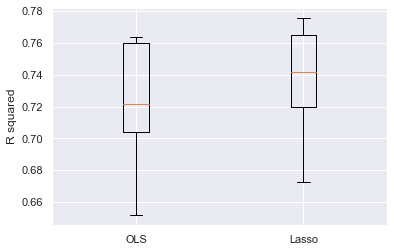

In [42]:
fig, ax = plt.subplots()
ax.boxplot([scores_full,scores_lasso])
plt.xticks([1, 2], ['OLS', 'Lasso'])
plt.ylabel('R squared')
#plt.title('Out-of-sample validation')
plt.savefig('plots\outofsample_validation_onJob.png', bbox_inches='tight')


NOTE: out-of-sample performance of regularized model (Lasso) appears to be better--> less noise in the data and thus no overfitting.

### 3.2. Open Education

In [43]:
nona = y_X.drop(columns = ["on_job"])
nona = nona.dropna()

y = nona["open_educ"]
X = nona.iloc[:, 1:]

# Now let's apply Benjamini - Hochberg as a first attempt to regularise the model 
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)
X = StandardScaler().fit_transform(X)

In [44]:
# Use K-fold out-of-sample validation to compare the predictive power of the full and of the reduced model
from sklearn.model_selection import KFold, cross_val_score

y = nona["open_educ"]
X = nona.iloc[:, 1:]

kf = KFold(n_splits=5, shuffle=True, random_state=1) # we use five splits, randam_state makes sure we can replacte the data (get same random numbers)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('regr', LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1))])
scores_full = cross_val_score(pipe, X, y, cv=kf)
print("scores full")
print(scores_full)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_full.mean(), scores_full.std() * 2))

scores full
[0.74249549 0.49722412 0.45756421 0.50581782 0.4055459 ]
Accuracy: 0.52173 (+/- 0.23187)


In [45]:
# optimal lasso penalty
from sklearn.linear_model import LassoCV
import time
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=5, max_iter=10000, alphas=np.logspace(-2.5, -0.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X, y)
t_cv = time.time() - t1
print("Ready")
l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.0650 
Training time =  0.2672s 


In [46]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
scores_lasso = cross_val_score(pipe, X, y, cv=kf)
print(scores_lasso)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_lasso.mean(), scores_lasso.std() * 2))

[0.74197499 0.52618623 0.49853986 0.53244716 0.43540138]
Accuracy: 0.54691 (+/- 0.20681)


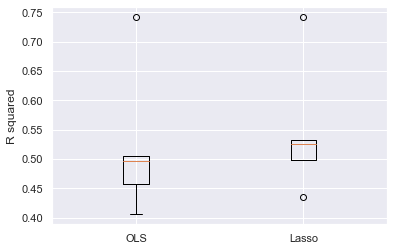

In [49]:
fig, ax = plt.subplots()
ax.boxplot([scores_full, scores_lasso])
plt.xticks([1, 2], ['OLS', 'Lasso'])
plt.ylabel('R squared')
#plt.title('Out-of-sample validation, open education')
#plt.savefig('results\plots\outofsample_validation_openEduc.png', bbox_inches='tight')
plt.savefig('plots\outofsample_validation_openEduc.png', bbox_inches='tight')


## 4. Lasso
### 4.1 Lasso - on the job training

In [50]:
# Use K-fold out-of-sample validation to select the 'best' $\lambda$. Plot average out-of-sample error as a function of $\lambda$. 
# Note: can take some time
from sklearn.linear_model import LassoCV
import time

nona = y_X.drop(columns = ["open_educ"])
nona = nona.dropna()

y = nona["on_job"]
X = nona.iloc[:, 1:]



# Now let's apply Benjamini - Hochberg as a first attempt to regularise the model 
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 


pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=0.05, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
# note alpha == lambda in the lecture notes; we just take some value - it is not the optimal! 
# again if you simply follow the defaults, it is not necessary to specify the options
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.7657
Out-of-sample Rsq:  0.7383


Computing regularization path using the lasso...
Ready


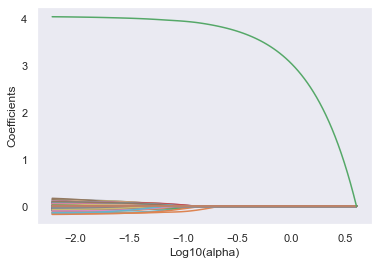

In [52]:
# lasso path
from sklearn.linear_model import lasso_path, enet_path

X = StandardScaler().fit_transform(X_train) 
# Compute paths
eps = 0.0015 #the smaller it is the longer is the path; 0 = OLS. If it is very small: the model might not find a solution
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y_train, eps=eps, max_iter=10000, fit_intercept=True)
print("Ready")

plt.figure()
log_alphas_lasso = np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    l1 = plt.plot(log_alphas_lasso, coef_l)

plt.xlabel('Log10(alpha)')
plt.ylabel('Coefficients')
#plt.title('Lasso Path')
plt.axis('tight')
plt.grid(axis='both')

plt.savefig('plots\lasso_path_onJob.png', bbox_inches='tight')
#plt.savefig('results\plots\lasso_path_onJob.png', bbox_inches='tight')
plt.show()


Lasso Path shows the path of estimated coefficients for different values of $\lambda$. When $\lambda$ approaches zero, we are close to the OLS with all the variables. The path also shows us the $\lambda$ when all the coefficients are zero (null model). For this graph such $\lambda$ is around log(-1). It is helpful for the next step, when we define the search grid to find the optimal $\lambda$. 
#### Selecting optimal $\lambda$ with cross-validation and information criteria

In [53]:
from sklearn.linear_model import LassoCV
import time

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=10, max_iter=10000, alphas=np.logspace(-3, -2.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X_train, y_train)
t_cv = time.time() - t1
print("Ready")

l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.0032 
Training time =  0.5969s 


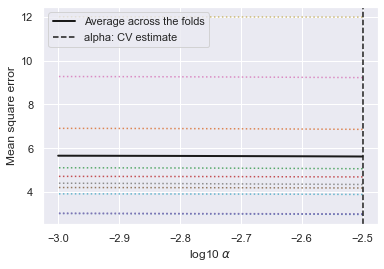

In [55]:
# Display results
log_alphas_lasso = np.log10(l.alphas_)

plt.figure()
plt.plot(log_alphas_lasso , l.mse_path_, ':')
plt.plot(log_alphas_lasso , l.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(np.log10(l.alpha_) , linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'log10 $\alpha$')
plt.ylabel('Mean square error')
#plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')
#plt.savefig('results\plots\lasso_MSE_fold_onJob.png', bbox_inches='tight')
plt.savefig('plots\lasso_MSE_fold_onJob.png', bbox_inches='tight')

Constant MSE 

##### Using the optimal alpha as calculated using the cross-validation

In [57]:

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])


pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.7756
Out-of-sample Rsq:  0.7227


In [58]:
# we can also check which coefficients were selected by LASSO 
pipe.named_steps['lasso'].coef_ # note the syntaxis pipe.named_steps

array([-0.00000000e+00,  1.30226495e-02, -0.00000000e+00,  8.59183636e-03,
        1.12688336e-01, -3.27932746e-02,  1.02488707e-01, -5.39060347e-02,
       -1.25095776e-02,  3.99261437e-02,  0.00000000e+00,  0.00000000e+00,
       -1.59404432e-02, -4.63831006e-04,  9.49296809e-02,  2.12925310e-02,
       -1.02173516e-01, -2.59667260e-02, -4.84433658e-02, -7.76335485e-03,
       -3.97903902e-02, -4.52186054e-02, -5.04805471e-02, -3.74340813e-02,
       -3.15948770e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        4.43277910e-02,  0.00000000e+00,  9.17084204e-02, -2.08258373e-02,
        0.00000000e+00,  5.43470724e-02,  6.59690760e-02, -2.15239594e-02,
       -9.34009233e-02, -1.97780822e-02,  4.07503152e-02, -1.39199590e-01,
       -4.02737785e-02,  2.29911447e-03, -5.06403928e-02, -3.01934943e-03,
       -4.30036235e-02,  2.67775321e-02, -2.51161674e-02,  5.77853068e-02,
        0.00000000e+00,  2.19610539e-02,  3.46087356e-02, -6.17387379e-03,
        4.12191984e-02,  

In [59]:
imp = pd.DataFrame(pipe.named_steps['lasso'].coef_, columns = ['Lasso coefficient'])
imp['Feature'] = list(X_train.columns)
imp

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [60]:
index = imp[(imp['Lasso coefficient'] == 0)].index
imp.drop(index, inplace=True)
imp

,Lasso coefficient
1,0.013023
3,0.008592
4,0.112688
5,-0.032793
6,0.102489
...,...
177,-0.028439
178,-0.065306
179,-0.147395
180,-0.009473


#### Lasso for open education

In [92]:
nona = y_X.drop(columns = ["on_job"])
nona = nona.dropna()
y = nona["open_educ"]
X = nona.iloc[:, 1:]

In [93]:
# Use K-fold out-of-sample validation to select the 'best' $\lambda$. Plot average out-of-sample error as a function of $\lambda$. 
# Note: can take some time
from sklearn.linear_model import LassoCV
import time



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 


pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=0.05, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
# note alpha == lambda in the lecture notes; we just take some value - it is not the optimal! 
# again if you simply follow the defaults, it is not necessary to specify the options
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.5308
Out-of-sample Rsq:  0.7432


Computing regularization path using the lasso...
Ready


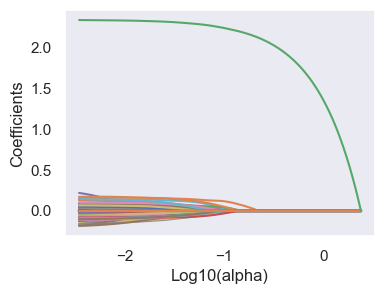

In [94]:
# lasso path
from sklearn.linear_model import lasso_path, enet_path

X = StandardScaler().fit_transform(X_train) 
# Compute paths
eps = 0.0015 #the smaller it is the longer is the path; 0 = OLS. If it is very small: the model might not find a solution
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y_train, eps=eps, max_iter=10000, fit_intercept=True)
print("Ready")

plt.figure()
log_alphas_lasso = np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    l1 = plt.plot(log_alphas_lasso, coef_l)

plt.xlabel('Log10(alpha)')
plt.ylabel('Coefficients')
#plt.title('Lasso Path')
plt.axis('tight')
plt.grid(axis='both')
plt.show()

#plt.savefig('results\plots\lasso_path_openeduc.png', bbox_inches='tight')

#### Selecting optimal $\lambda$ with cross-validation and information criteria

In [95]:
from sklearn.linear_model import LassoCV
import time

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=10, max_iter=10000, alphas=np.logspace(-3, -2.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X_train, y_train)
t_cv = time.time() - t1
print("Ready")

l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.0032 
Training time =  0.7461s 


(-3.025, -2.475, 2.5352896442008968, 12.442786028008149)

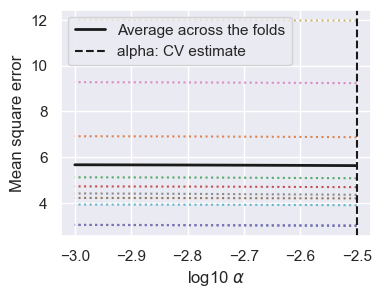

In [96]:
# Display results
log_alphas_lasso = np.log10(l.alphas_)

plt.figure()
plt.plot(log_alphas_lasso , l.mse_path_, ':')
plt.plot(log_alphas_lasso , l.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(np.log10(l.alpha_) , linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'log10 $\alpha$')
plt.ylabel('Mean square error')
#plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')
#plt.savefig('results\plots\lasso_MSE_fold_openeduc.png', bbox_inches='tight')

In [97]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])

pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.5507
Out-of-sample Rsq:  0.7431


In [98]:
# we can also check which coefficients were selected by LASSO 
pipe.named_steps['lasso'].coef_ # note the syntaxis pipe.named_steps

array([ 0.00000000e+00, -1.29512284e-02,  4.60723628e-05, -8.35198854e-03,
       -1.12447633e-01,  3.32347100e-02, -1.02344850e-01,  5.36110386e-02,
        1.25395481e-02, -3.98106515e-02,  0.00000000e+00,  0.00000000e+00,
        1.60908020e-02,  3.48396373e-04, -9.46400184e-02, -2.15004874e-02,
        1.01935954e-01,  2.57621373e-02,  4.90292993e-02,  7.70112579e-03,
        3.98758806e-02,  4.51446904e-02,  5.03808021e-02,  3.79251213e-02,
        3.06276796e-03, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.43211139e-02, -0.00000000e+00, -9.17875021e-02,  2.05923235e-02,
       -0.00000000e+00, -5.46986056e-02, -6.58663596e-02,  2.19642375e-02,
        9.35319372e-02,  1.97884774e-02, -4.09260140e-02,  1.39018465e-01,
        4.08613258e-02, -1.23315143e-03,  5.06243582e-02,  2.84118944e-03,
        4.28103744e-02, -2.70483482e-02,  2.49991507e-02, -5.79702554e-02,
       -0.00000000e+00, -2.23259655e-02, -3.48203091e-02,  6.20875552e-03,
       -4.08640926e-02, -

In [99]:
imp = pd.DataFrame(pipe.named_steps['lasso'].coef_, columns = ['Lasso coefficient'])
imp['Feature'] = list(X_train.columns)
imp

,Lasso coefficient,Feature
0,0.000000,age_r
1,-0.012951,j_q03b
2,0.000046,yrsget
3,-0.008352,c_q09
4,-0.112448,c_q10a
...,...,...
178,0.065309,computerexperience_Yes
179,0.147334,skill_1
180,0.009336,skill_2
181,0.000000,skill_3


In [100]:
index = imp[(imp['Lasso coefficient'] == 0)].index
imp.drop(index, inplace=True)
imp

,Lasso coefficient,Feature
1,-0.012951,j_q03b
2,0.000046,yrsget
3,-0.008352,c_q09
4,-0.112448,c_q10a
5,0.033235,readytolearn
...,...,...
177,0.028321,b_q10a_Yes
178,0.065309,computerexperience_Yes
179,0.147334,skill_1
180,0.009336,skill_2


### 4.3 All training

In [102]:
y_X['training'] = y_X["open_educ"] + y_X["on_job"]
nona = y_X.drop(columns = ["open_educ", "on_job"])
nona = nona.dropna()
y = nona["training"]
X = nona.drop(columns = ["training"])
X = nona.iloc[:, 1:]

In [103]:
# Use K-fold out-of-sample validation to select the 'best' $\lambda$. Plot average out-of-sample error as a function of $\lambda$. 
# Note: can take some time
from sklearn.linear_model import LassoCV
import time



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 


pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=0.05, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
# note alpha == lambda in the lecture notes; we just take some value - it is not the optimal! 
# again if you simply follow the defaults, it is not necessary to specify the options
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.9999
Out-of-sample Rsq:  0.9999


Computing regularization path using the lasso...
Ready


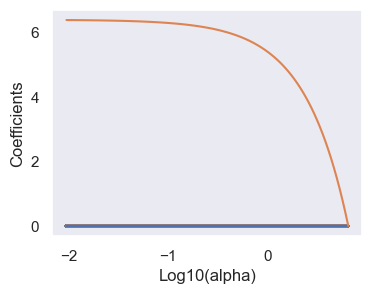

<Figure size 400x300 with 0 Axes>

In [104]:
# lasso path
from sklearn.linear_model import lasso_path, enet_path

X = StandardScaler().fit_transform(X_train) 
# Compute paths
eps = 0.0015 #the smaller it is the longer is the path; 0 = OLS. If it is very small: the model might not find a solution
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y_train, eps=eps, max_iter=10000, fit_intercept=True)
print("Ready")

plt.figure()
log_alphas_lasso = np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    l1 = plt.plot(log_alphas_lasso, coef_l)

plt.xlabel('Log10(alpha)')
plt.ylabel('Coefficients')
#plt.title('Lasso Path')
plt.axis('tight')
plt.grid(axis='both')
plt.show()

#plt.savefig('results\plots\lasso_path_openeduc.png', bbox_inches='tight')
plt.savefig('plots\lasso_path_alltraining.png', bbox_inches='tight')

#### Selecting optimal $\lambda$ with cross-validation and information criteria

In [105]:
from sklearn.linear_model import LassoCV
import time

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=10, max_iter=10000, alphas=np.logspace(-3, -2.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X_train, y_train)
t_cv = time.time() - t1
print("Ready")

l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.0010 
Training time =  0.3556s 


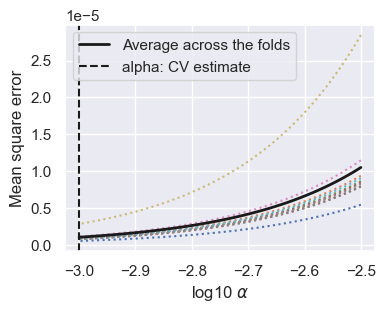

In [106]:
# Display results
log_alphas_lasso = np.log10(l.alphas_)

plt.figure()
plt.plot(log_alphas_lasso , l.mse_path_, ':')
plt.plot(log_alphas_lasso , l.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(np.log10(l.alpha_) , linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'log10 $\alpha$')
plt.ylabel('Mean square error')
#plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')
#plt.savefig('results\plots\lasso_MSE_fold_openeduc.png', bbox_inches='tight')

plt.savefig('plots\lasso_MSE_fold_alltraining.png', bbox_inches='tight')

In [107]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])

pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  1.0000
Out-of-sample Rsq:  1.0000


In [108]:
# we can also check which coefficients were selected by LASSO 
pipe.named_steps['lasso'].coef_ # note the syntaxis pipe.named_steps

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.  

In [109]:
imp = pd.DataFrame(pipe.named_steps['lasso'].coef_, columns = ['Lasso coefficient'])
imp['Feature'] = list(X_train.columns)
imp

,Lasso coefficient,Feature
0,0.00000,j_q03b
1,0.00000,yrsget
2,0.00000,c_q09
3,0.00000,c_q10a
4,0.00000,readytolearn
...,...,...
177,0.00000,computerexperience_Yes
178,0.00000,skill_1
179,-0.00000,skill_2
180,-0.00000,skill_3


In [110]:
index = imp[(imp['Lasso coefficient'] == 0)].index
imp.drop(index, inplace=True)
imp

,Lasso coefficient,Feature
181,6.38484,training


## 5. Random Forest 

### 5.1 Open Education

In [149]:
nona = y_X.drop(columns = ["on_job","training"])
nona = nona.dropna()
y = nona["open_educ"]
X = nona.iloc[:, 1:]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 



In [150]:

rf = ensemble.RandomForestRegressor(n_estimators = 50, min_samples_leaf = 1, oob_score = True, \
        random_state = 1, max_features = int(X_train.shape[1]/3))
rf = rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Out-of-sample Rsq: -0.026
Out-of-sample MSE: 16.436


In [151]:
# we can check whether we had enough trees in the forest
# Use cross-validation to determine the optimal number of trees
from sklearn.model_selection import cross_validate
import scipy as sp

def cv_iter(n, folds, X, y):
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    rf = ensemble.RandomForestRegressor(n_estimators = n, min_samples_leaf = 1, \
        random_state = 1)
    cv_result = cross_validate(rf, X, y, scoring = 'neg_mean_squared_error')
    avg_score = np.mean(cv_result['test_score'])
    return float(-avg_score)

<AxesSubplot:xlabel='Number of trees'>

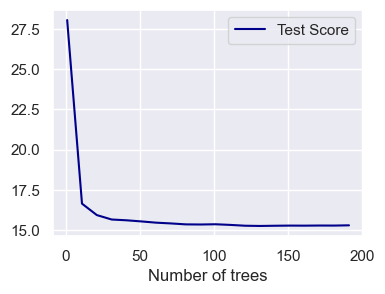

In [152]:


result = {}
for i in range(1, 200, 10):
    result[i] = cv_iter(i, 5, X_train, y_train)

plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Number of trees')

# as we can see on the graph below, the MSE stabilizes with about 50 trees. 

In [154]:
# feature importance

imp = pd.DataFrame(rf.feature_importances_, columns = ['Feature importance'])
imp['Feature'] = list(X_train.columns)
imp.sort_values(by=['Feature importance'], ascending=False).reset_index(drop = True)


,Feature importance,Feature
0,0.069636,earnmthallppp
1,0.057150,age_r
2,0.049641,readytolearn
3,0.036277,c_q09
4,0.022686,yrsget
...,...,...
177,0.000000,cntryid_Sweden
178,0.000000,cntryid_84093.0
179,0.000000,cntryid_Austria
180,0.000000,cntryid_Finland


#### For comparison - fitting a single decision tree

In [155]:
# put here the parameters for max_depth and min_samples_leaf that you determined in the previous step

cart = tree.DecisionTreeRegressor()
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Tree depth: 47
Out-of-sample Rsq: -1.112
Out-of-sample MSE: 33.849


In [156]:
from sklearn.model_selection import cross_validate
import scipy as sp

# write a function that runs a CV procedure for a candidate model of a given depth or with a given number of nodes
def cv_iter(max_depth, max_leaf_nodes, min_leafs, folds, X, y):
    kf = KFold(n_splits=folds, shuffle=True, random_state=1) # settings for CV
    cart = tree.DecisionTreeRegressor(max_depth = max_depth, max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_leafs, random_state = 1) # settings for CART
    cv_result = cross_validate(cart, X, y, scoring = 'neg_mean_squared_error') # output for CV, scoring = what is returned
    avg_score = np.mean(cv_result['test_score']) #average resutl for our N-folds
    return float(-avg_score)

1

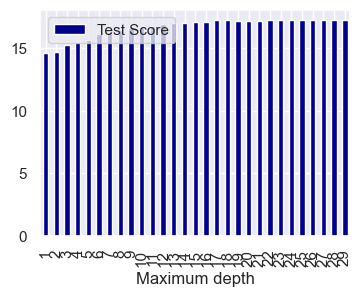

In [157]:
# Result when we iterate over candidate models of different depth
# Note: you can also try to iterate over models with a different number of nodes (see the lecture slides). 
result = {}
for i in range(1, 30):
    result[i] = cv_iter(i, None, 10, 5, X_train, y_train) #max_depth, max_leaf_nodes, min_samples_leaf, folds, X, y

plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot.bar(color = 'DarkBlue', xlabel = 'Maximum depth')

results['Test Score'].idxmin()

Tree depth: 1
Out-of-sample Rsq: -0.007
Out-of-sample MSE: 16.133


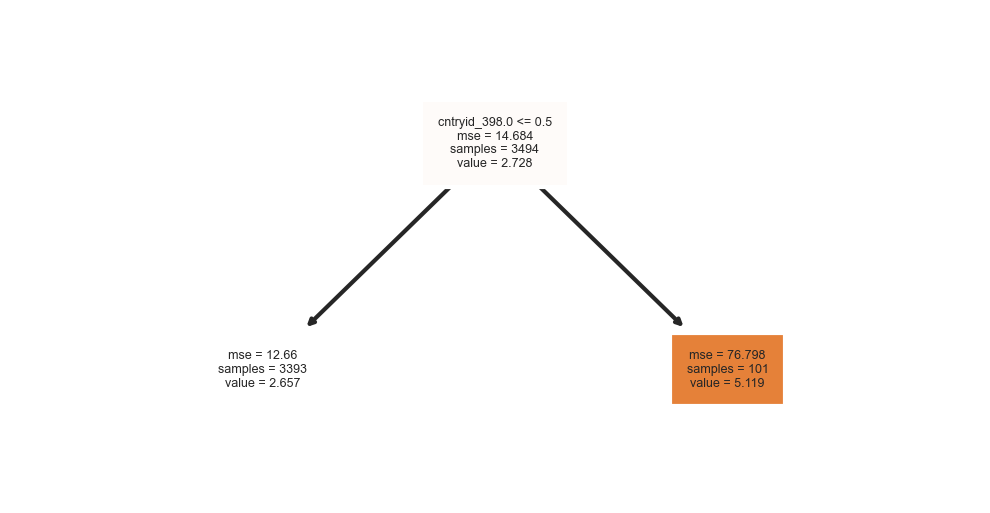

In [158]:
cart = tree.DecisionTreeRegressor( min_samples_leaf = 26, max_depth = results['Test Score'].idxmin(), random_state = 1)
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# try to change the parameters and check how the OOS performance changes
# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

#dendrogram
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300})
tree.plot_tree(cart, max_depth = 5, filled = True, feature_names = list(X.columns),\
               fontsize = 3);

####  Pruning with Minimal Cost-Complexity

This pruning technique is parameterized by the cost complexity parameter, ccp_alpha. Greater values of ccp_alpha increase the number of nodes pruned. 
The goal is the find an optimal value of α which gives the maximum validation/test set accuracy.

- Parameter ccp_alpha provides a threshold for effective alphas, i.e. the process of pruning continues until the minimal effective alpha of the pruned tree is not greater than ccp_alpha. 

- The DecisionTreeClassifier class also provides a method cost_complexity_pruning_path which implements the pruning process and returns the effective alphas(and the corresponding impurities of there pruned trees)

In [159]:
# Complexity path 
# Note: here we don't need to set additional stopping rules. 
# The algorithm determines the optimal alpha, which fixes the number of terminal nodes.  

cart = tree.DecisionTreeRegressor(random_state = 1)

path = cart.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

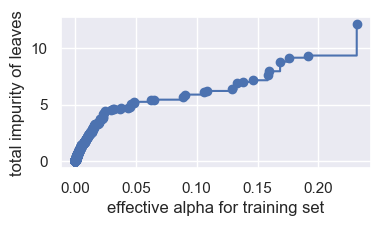

In [160]:
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 100})
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha for training set")
ax.set_ylabel("total impurity of leaves")
#ax.set_title("Total Impurity vs effective alpha for training set - open education")
plt.savefig('plots\costcomplexPruning_openeduc.png', bbox_inches='tight')
# Based on this graph, where would you expect the optimal alpha to be? 

As it is evident from the above plot, a value of alpha close to 0 corresponds to minimum impurity(unpruned tree) and as the value of alpha becomes larger the tree tends to be more impure.

In [161]:
# we define a function for cross-validation
def cv_iter(alpha, folds, X, y):
    cart = tree.DecisionTreeRegressor(ccp_alpha = alpha)
    cv_result = cross_validate(cart, X, y, scoring = 'neg_mean_squared_error')
    avg_score = np.mean(cv_result['test_score'])
    return float(-avg_score)

6.000000000000001e-05

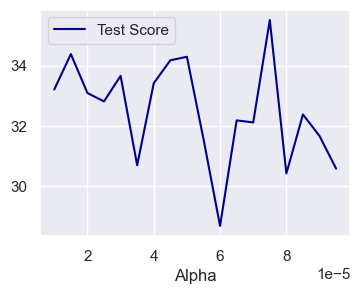

In [162]:
# attention: this CV takes some time, as we are fitting many forests, would suggest doing this in the very end... 
result = {}
for i in np.arange(0.00001, 0.0001, 0.000005): # you can also try a different grid for search 
    result[i] = cv_iter(i, 3, X_train, y_train)

plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Alpha')

results['Test Score'].idxmin()

Tree depth: 47
Out-of-sample Rsq: -1.353
Out-of-sample MSE: 37.713


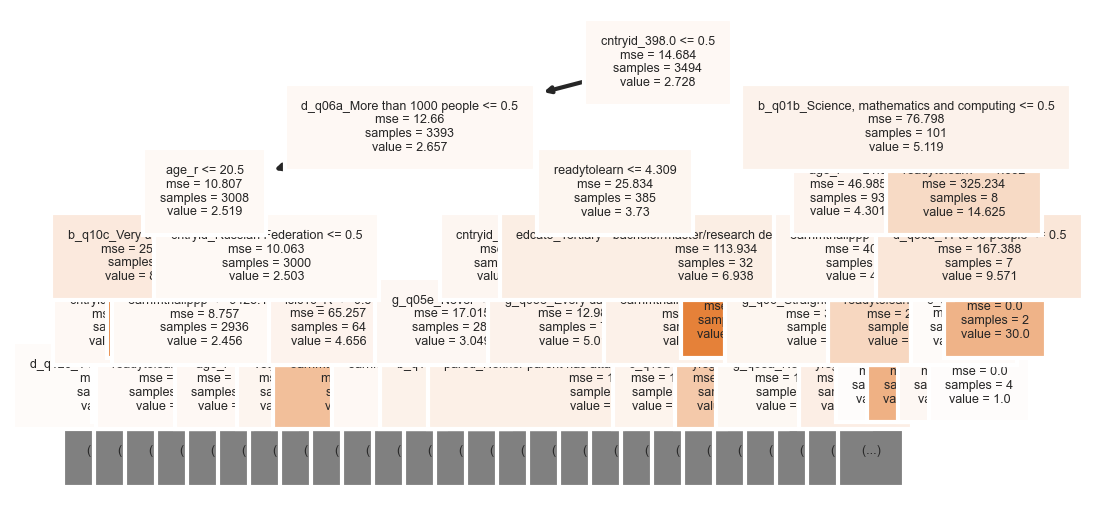

In [163]:
cart = tree.DecisionTreeRegressor( ccp_alpha = results['Test Score'].idxmin(), random_state = 1)
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# try to change the parameters and check how the OOS performance changes
# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

#dendrogram
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300})
tree.plot_tree(cart, max_depth = 5, filled = True, feature_names = list(X.columns),\
               fontsize = 3);

### 5.2 On the job training

In [169]:
nona = y_X.drop(columns = ["open_educ", "training"])
nona = nona.dropna()
y = nona["on_job"]
X = nona.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 

#### Random forest 
with extra randomization (for each individual tree, we randomly select a subsample of covariates from X to split on)

In [170]:

rf = ensemble.RandomForestRegressor(n_estimators = 50, min_samples_leaf = 1, oob_score = True, \
        random_state = 1, max_features = int(X_train.shape[1]/3))
rf = rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Out-of-sample Rsq: 0.016
Out-of-sample MSE: 14.856


Another random forest - without extra randomization

- this random forest without extra randomization yields a higher out-of-sample $R^2$

In [171]:


rf = ensemble.RandomForestRegressor(n_estimators = 100, min_samples_leaf = 1, min_samples_split = 2, oob_score = True, \
        random_state = 1)
rf = rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Out-of-sample Rsq: 0.005
Out-of-sample MSE: 15.014


To check whether we had enough trees in the forest we use cross-validation to determine the optimal number of trees

In [172]:

from sklearn.model_selection import cross_validate
import scipy as sp

def cv_iter(n, folds, X, y):
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    rf = ensemble.RandomForestRegressor(n_estimators = n, min_samples_leaf = 1, \
        random_state = 1)
    cv_result = cross_validate(rf, X, y, scoring = 'neg_mean_squared_error')
    avg_score = np.mean(cv_result['test_score'])
    return float(-avg_score)

<AxesSubplot:xlabel='Number of trees'>

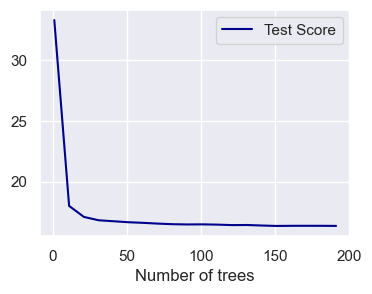

In [173]:
result = {}
for i in range(1, 200, 10):
    result[i] = cv_iter(i, 5, X_train, y_train)

plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Number of trees')

# as we can see on the graph below, the MSE stabilizes with about 25 trees. 

In [174]:
# feature importance

imp = pd.DataFrame(rf.feature_importances_, columns = ['Feature importance'])
imp['Feature'] = list(X_train.columns)
imp.sort_values(by=['Feature importance'], ascending=False).reset_index(drop = True)


,Feature importance,Feature
0,0.079164,earnmthallppp
1,0.064813,readytolearn
2,0.047799,age_r
3,0.041058,c_q09
4,0.031330,c_q10a
...,...,...
177,0.000000,cntryid_348.0
178,0.000000,c_q02a_Yes
179,0.000000,cntryid_604.0
180,0.000000,cntryid_702.0


#### For comparison - fitting a single decision tree

In [175]:
# put here the parameters for max_depth and min_samples_leaf that you determined in the previous step

cart = tree.DecisionTreeRegressor()
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Tree depth: 45
Out-of-sample Rsq: -1.107
Out-of-sample MSE: 31.802


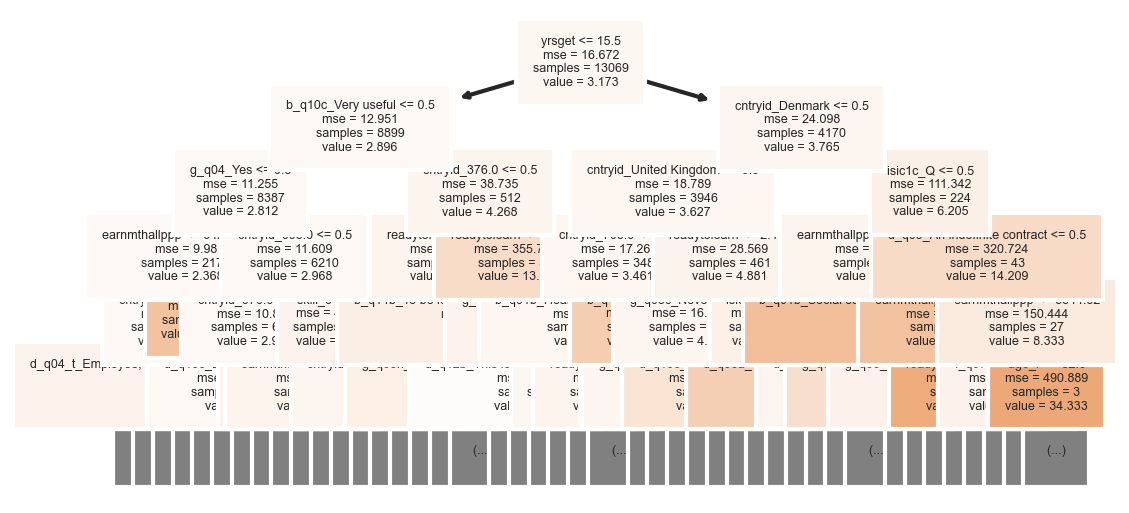

In [176]:
#dendrogram
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300})
tree.plot_tree(cart, max_depth = 5, filled = True, feature_names = list(X.columns),\
               fontsize = 3);

###  Pruning with Minimal Cost-Complexity

This pruning technique is parameterized by the cost complexity parameter, ccp_alpha. Greater values of ccp_alpha increase the number of nodes pruned. 
The goal is the find an optimal value of α which gives the maximum validation/test set accuracy.

- Parameter ccp_alpha provides a threshold for effective alphas, i.e. the process of pruning continues until the minimal effective alpha of the pruned tree is not greater than ccp_alpha. 

- The DecisionTreeClassifier class also provides a method cost_complexity_pruning_path which implements the pruning process and returns the effective alphas(and the corresponding impurities of there pruned trees)

In [177]:
# Complexity path 
cart = tree.DecisionTreeRegressor(random_state = 1)

path = cart.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

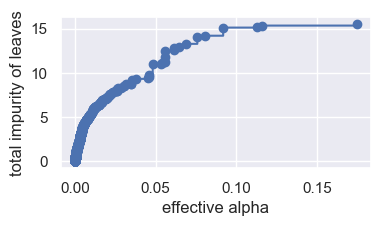

In [178]:
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 100})
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
#ax.set_title("Total Impurity vs effective alpha for training set - open education")
plt.savefig('plots\costcomplexPruning_onjob.png', bbox_inches='tight')
# Based on this graph, where would you expect the optimal alpha to be? 

As it is evident from the above plot, a value of alpha close to 0 corresponds to minimum impurity(unpruned tree) and as the value of alpha becomes larger the tree tends to be more impure.

In [179]:
# we define a function for cross-validation
def cv_iter(alpha, folds, X, y):
    cart = tree.DecisionTreeRegressor(ccp_alpha = alpha)
    cv_result = cross_validate(cart, X, y, scoring = 'neg_mean_squared_error')
    avg_score = np.mean(cv_result['test_score'])
    return float(-avg_score)

5.000000000000001e-05

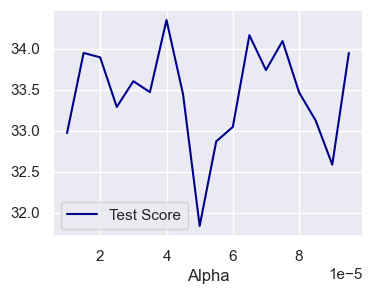

In [180]:
# attention: this CV takes some time, as we are fitting many forests, would suggest doing this in the very end... 
result = {}
for i in np.arange(0.00001, 0.0001, 0.000005): # you can also try a different grid for search 
    result[i] = cv_iter(i, 3, X_train, y_train)

plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Alpha')

results['Test Score'].idxmin()

Tree depth: 45
Out-of-sample Rsq: -1.064
Out-of-sample MSE: 31.149


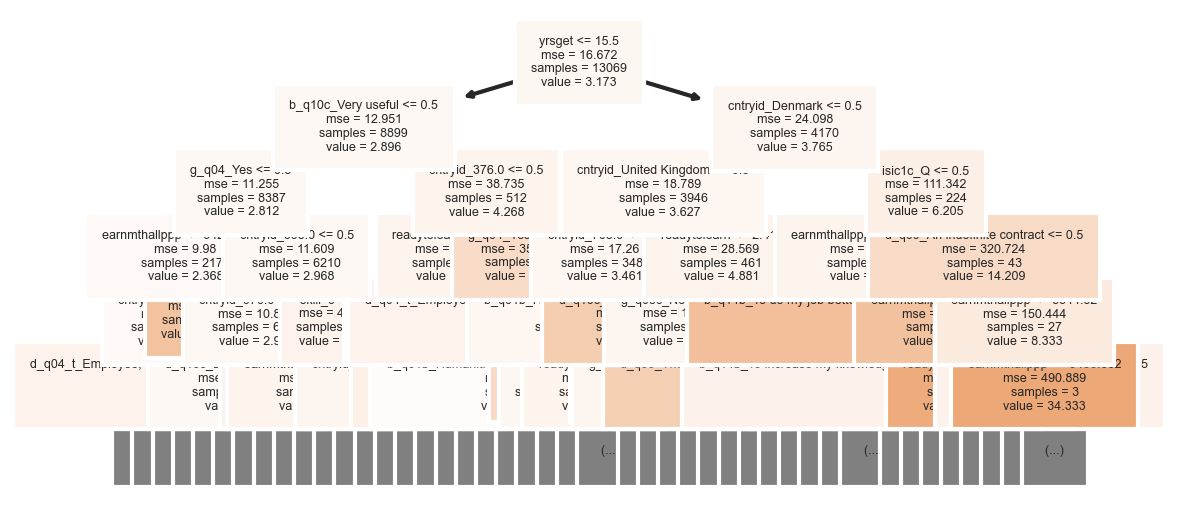

In [181]:
# put here the parameter for ccp_alpha that you determined in the previous step 

cart = tree.DecisionTreeRegressor( ccp_alpha = results['Test Score'].idxmin(), random_state = 1)
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# try to change the parameters and check how the OOS performance changes
# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

#dendrogram
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300})
tree.plot_tree(cart, max_depth = 5, filled = True, feature_names = list(X.columns),\
               fontsize = 3);